In [1]:
'''
from gen_dataset import *


def fetch_filter_data(filters):
    filter_dict = {}

    for name, filepath in filters:
        try:
            with open(filepath, 'r') as file:
                wavelength, transmission = [], []

                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        try:
                            wavelength.append(float(parts[0]))
                            transmission.append(float(parts[1]))
                        except ValueError:
                            continue  # Skip malformed lines

                filter_dict[name] = {
                    "wl": wavelength,
                    "tr": transmission
                }
        except FileNotFoundError:
            print(f"File not found for {name}: {filepath}")
        except Exception as e:
            print(f"Error reading file for {name}: {e}")

    return filter_dict

# Example local filter file paths
filters = [
    ['HSCg', 'HSC_bands/HSC.g_filter.dat'],
    ['HSCr', 'HSC_bands/HSC.r_filter.dat'],
    ['HSCi', 'HSC_bands/HSC.i_filter.dat'],
    ['HSCz', 'HSC_bands/HSC.z_filter.dat'],
    ['HSCY', 'HSC_bands/HSC.Y_filter.dat']
]

filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)


reader = SpectrumReader('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
lages, lmets, flx, wl = reader.read()

# Setup interpolator and processor
interpolator = SpectrumInterpolator(lages, lmets, flx)
processor = SpectrumProcessor(interpolator)

# Setup photometric calculator with filters
photocalc = PhotometricCalculator(spec_range=(3900, 10200), spec_points=100, filter_data=filter_data)

# Create DatasetBuilder with processor, wavelength grid and photocalc
builder = DatasetBuilder(processor, wl, photocalc)

# Generate dataset (already includes photometry and augmentation)
integrals, params, spectra = builder.generate(n_samples=128000, age_range=(10, 15000),
                                              young_age_range=(10, 1000),
                                              young_age_threshold=4000,
                                              old_blend_prob=0.0,
                                              young_extinction_prob=0.2, 
                                              eml_prob=0.0, 
                                              n_processes=8)

# Postprocessing (params normalization already done in DatasetBuilder)
# Normalize spectra (just in case, or omit if confident)
spectra /= np.max(spectra, axis=1)[:, None]

'''

from mkdataset_cigale import mkdataset_cigale

[ 0.24756583  0.01540974 -0.41027457]


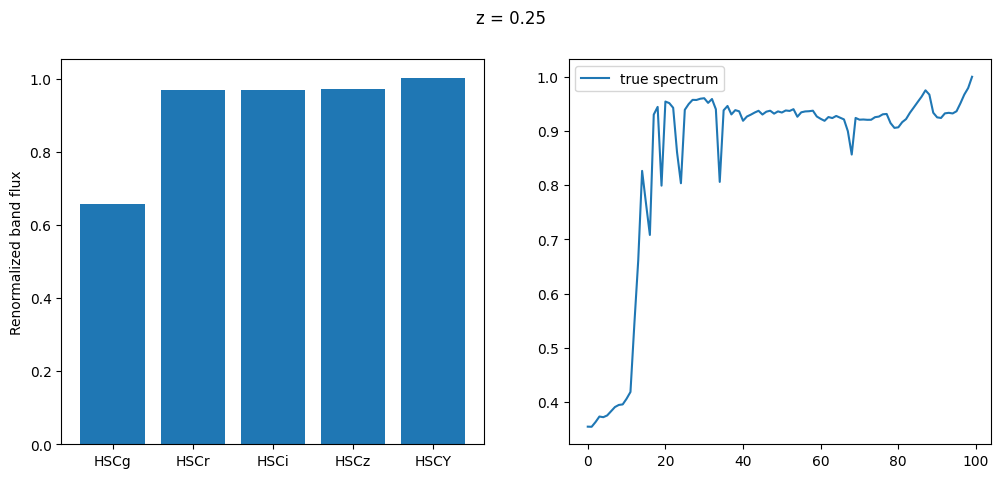

[ 0.24756583  0.01540974 -0.41027457]


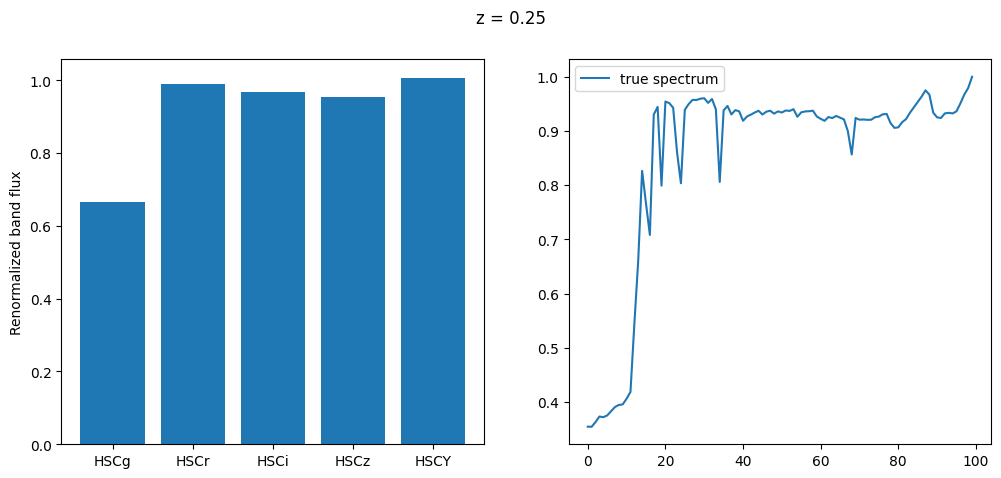

[ 0.24756583  0.01540974 -0.41027457]


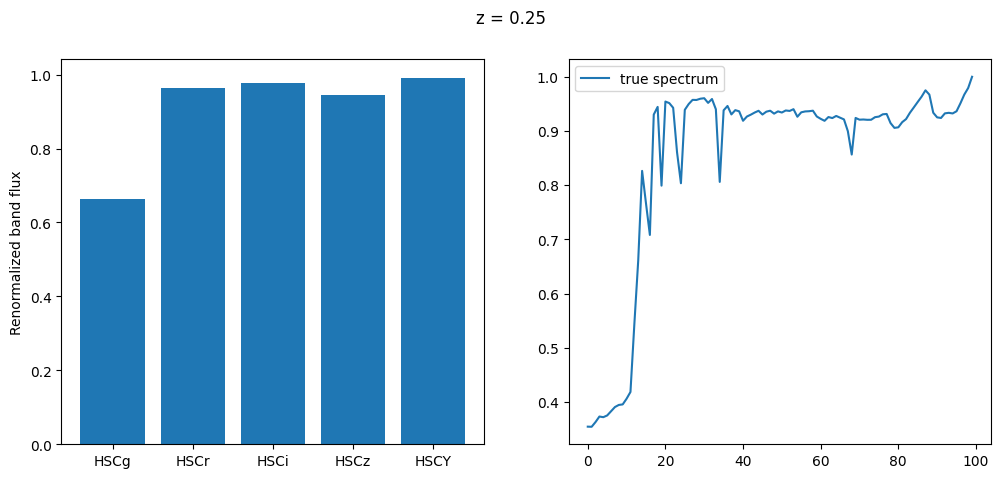

[ 0.24756583  0.01540974 -0.41027457]


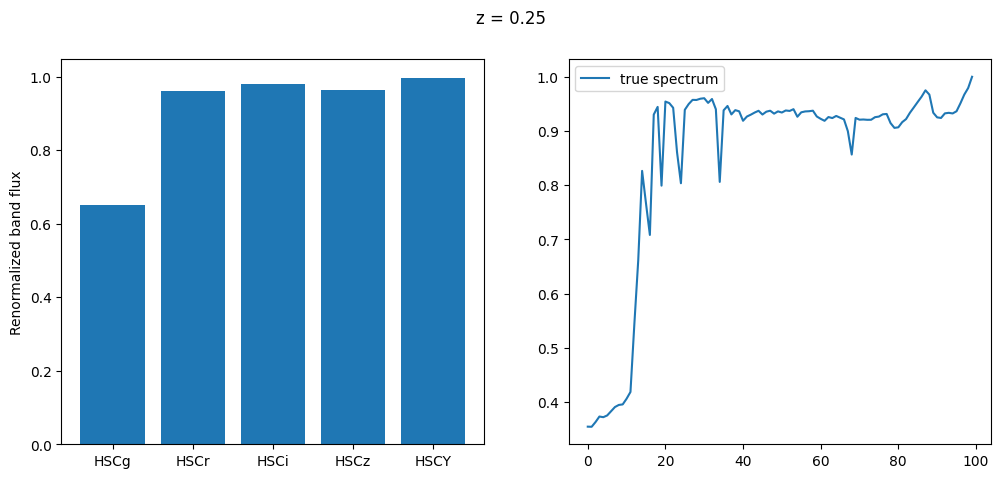

[ 0.24756583  0.01540974 -0.41027457]


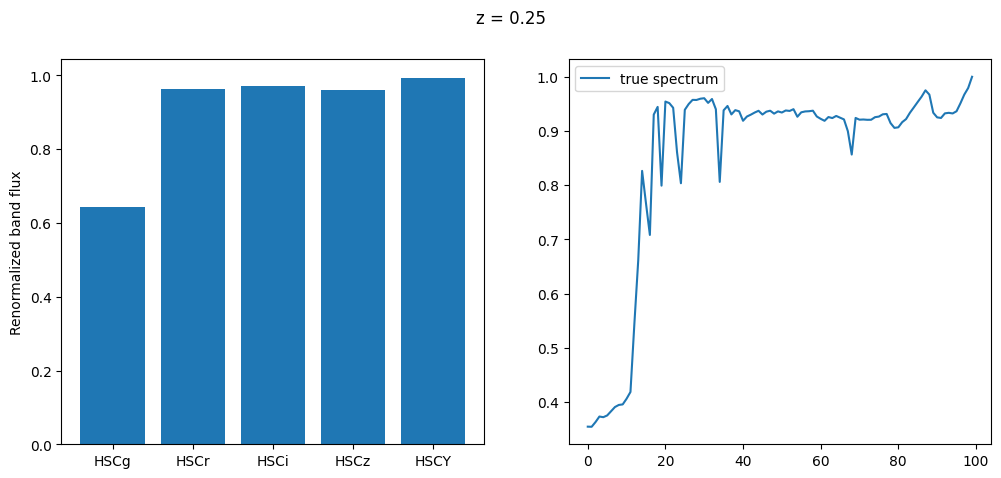

[ 0.24756583  0.01540974 -0.41027457]


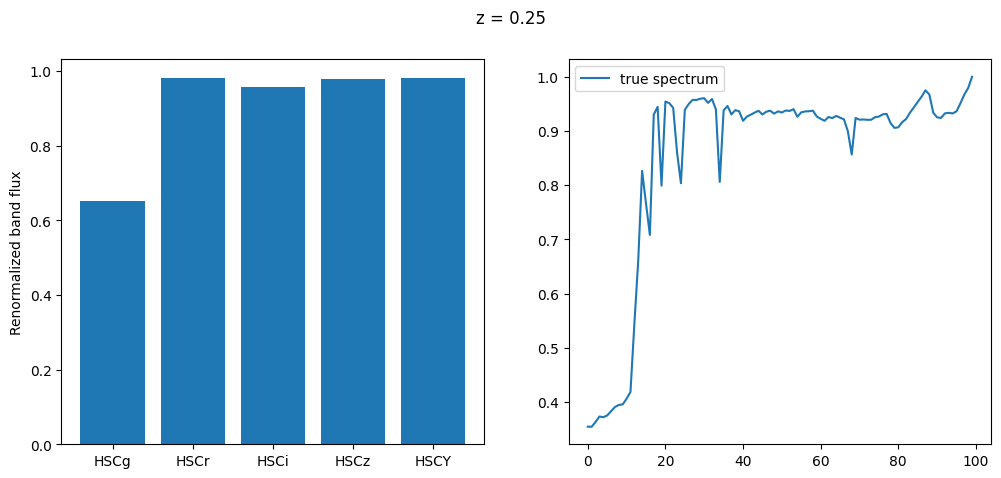

[ 0.24756583  0.01540974 -0.41027457]


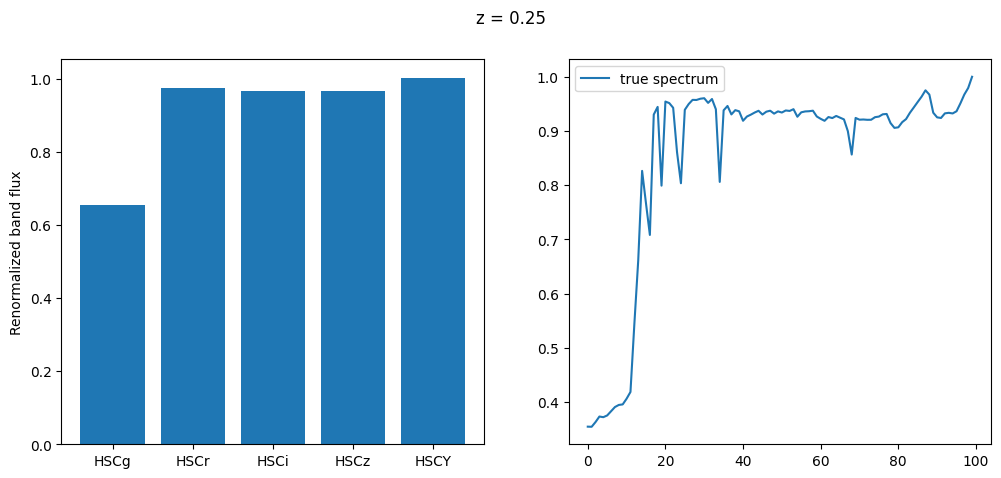

[ 0.24756583  0.01540974 -0.41027457]


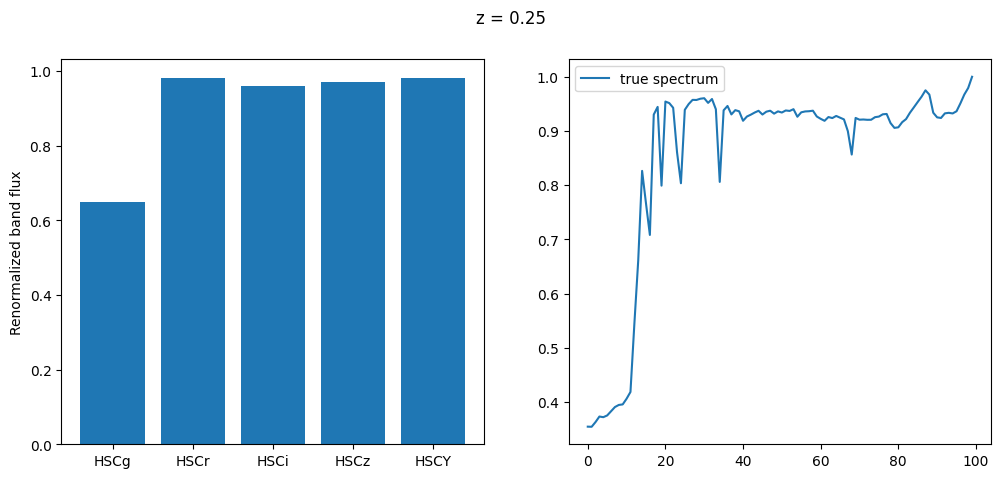

[ 0.24756583  0.01540974 -0.41027457]


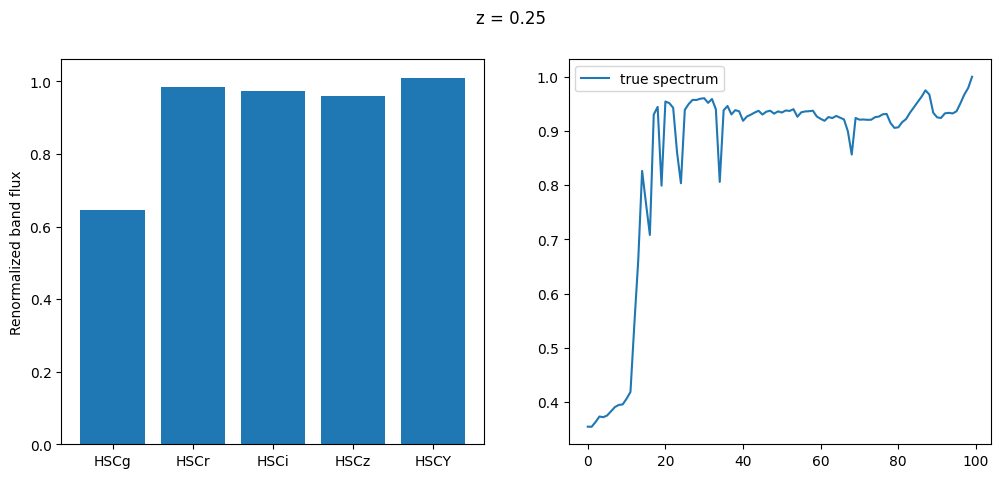

[ 0.24756583  0.01540974 -0.41027457]


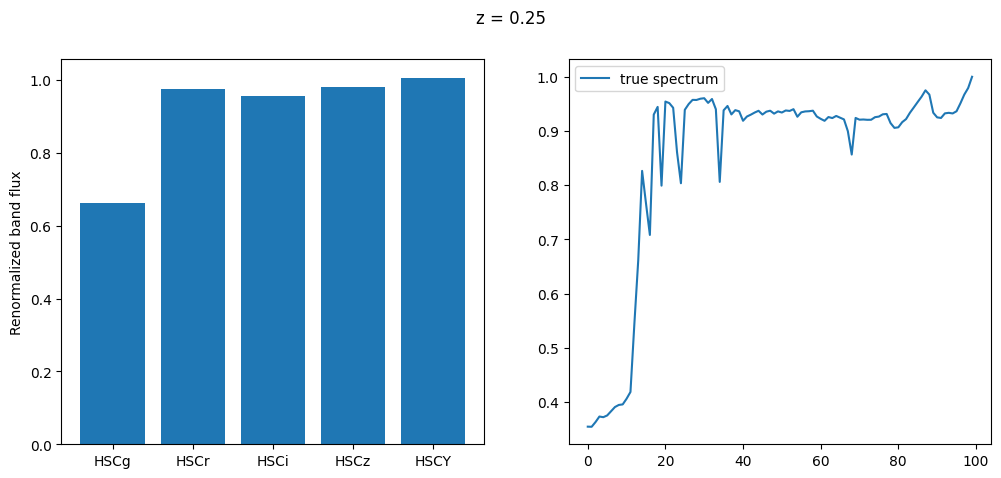

In [2]:
'''
import matplotlib.pyplot as plt

idx = np.where(((params[:, 0] <0.3) & (params[:, 0] >0.2) & (params[:, 1] < 0.15)))[0]

ii=idx[0]
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    #axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

'''

In [8]:
from mkdataset_cigale import *
import matplotlib.pyplot as plt
from astropy.table import Table

integrals, params, spectra, wl_spec = mkdataset_cigale(perturbation_sigmas = [0.003] * 5)

params[:, 1] *=1e-4

1000


In [9]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.0) & (t_hsc_['z'] < 1.5))]


34.580764318947786 0.12922914209229447
[19.406174 18.772152 18.413784 18.251953 18.07089 ]
[0.00162661 0.00156409 0.00096695 0.00154132 0.0024853 ]


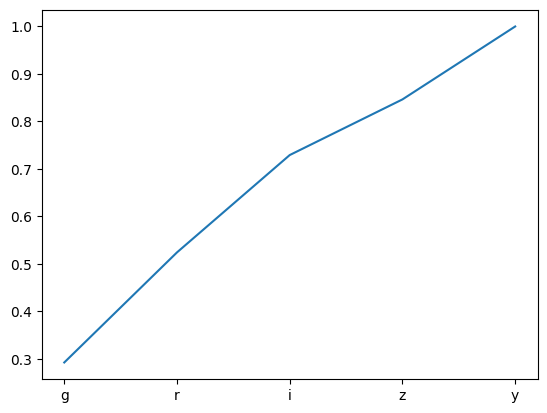

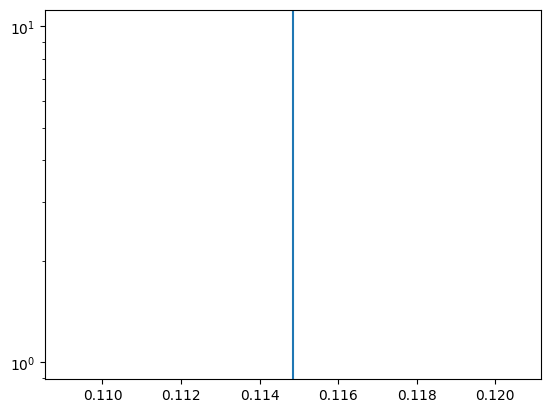

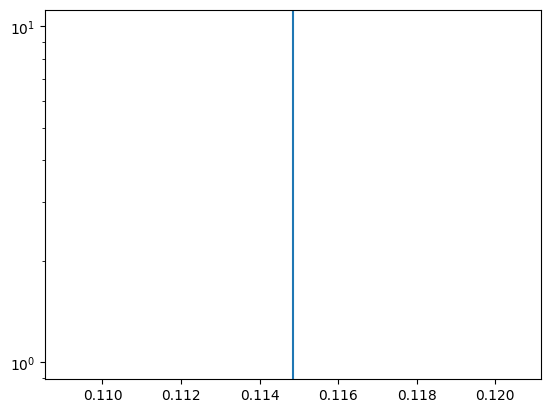

In [17]:
filters = ['g', 'r', 'i', 'z', 'y']
#target_id = 39627821542282195

target_id = 39627791347485767

r = t_hsc[t_hsc['targetid'] == target_id][0]

print(r['ra'], r['dec'])

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
errs = np.array([r['g_kronflux_magerr'], r['r_kronflux_magerr'], r['i_kronflux_magerr'], r['z_kronflux_magerr'], r['y_kronflux_magerr']])

print(mags)
print(errs)
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals[:, :] - bandfl[:])**2, axis=-1)

idx = np.where(rall < 5*0.01**2)[0]

p_v = params[idx]


plt.plot(filters, integrals[idx].T, color='grey', alpha=0.1)
plt.plot(filters, bandfl)

plt.show()

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.yscale('log')
plt.axvline(r['z'])

plt.show()

plt.plot(p_v[:, 0], p_v[:, 2], 'k+')
plt.yscale('log')
plt.axvline(r['z'])

plt.show()

In [11]:
ii = 1
z_ = 0.0
age_ = 13000
list_sed_templ = glob.glob('/data/kirg/MMVAE/SED_BPZ/*.sed')

print("\n".join(list_sed_templ))

idx = np.where((np.abs(params[:, 0] - z_) < 0.01) & (np.abs(params[:, 1] - age_) < 0.1*age_))[0]

print('Idx: ', idx)

sp = spectra[idx[0]]
wl = wl_spec[0]
sp = sp / wl**2

print(params[0])


t = Table.read(list_sed_templ[ii], format='ascii.no_header')
wl0 = t['col1']
flx0 = t['col2']

c = np.nanmax(flx0[((wl0 > 3900) & (wl0 < 10200))])

plt.plot(wl0, flx0 / c )
plt.xscale('log')
plt.yscale('log')

plt.plot(wl, sp/np.nanmax(sp))


plt.show()


/data/kirg/MMVAE/SED_BPZ/SB3_B2004a.sed
/data/kirg/MMVAE/SED_BPZ/El_B2004a.sed
/data/kirg/MMVAE/SED_BPZ/Im_B2004a.sed
/data/kirg/MMVAE/SED_BPZ/Sbc_B2004a.sed
/data/kirg/MMVAE/SED_BPZ/ssp_5Myr_z008.sed
/data/kirg/MMVAE/SED_BPZ/Scd_B2004a.sed
/data/kirg/MMVAE/SED_BPZ/ssp_25Myr_z008.sed
/data/kirg/MMVAE/SED_BPZ/SB2_B2004a.sed
Idx:  []


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import random
z = r['z']

idx = np.where((np.abs(params[:, 0] - z) < 0.01) & (np.abs(params[:, 1] - 0.1) < 0.3))[0]

print(len(idx))

random.shuffle(idx)

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
for i in range(0, 10):
    comp = integrals[idx[i]]
    comp_spec = spectra[idx[i]]
    axs[0].plot(filer_names, comp, color='grey', alpha=0.2)
    axs[1].plot(comp_spec, color='grey', alpha=0.2)

axs[0].plot(filer_names, bandfl)
axs[0].set_ylabel('Renormalized band flux')
plt.legend()
plt.show()

eps = 0.0050: bp_arr = 78, zgood_arr = 54
eps = 0.0075: bp_arr = 186, zgood_arr = 129
eps = 0.0100: bp_arr = 283, zgood_arr = 210
eps = 0.0125: bp_arr = 402, zgood_arr = 301
eps = 0.0150: bp_arr = 478, zgood_arr = 358
eps = 0.0175: bp_arr = 533, zgood_arr = 408
eps = 0.0200: bp_arr = 587, zgood_arr = 461
eps = 0.0225: bp_arr = 636, zgood_arr = 490
eps = 0.0250: bp_arr = 686, zgood_arr = 524
eps = 0.0275: bp_arr = 718, zgood_arr = 549
eps = 0.0300: bp_arr = 748, zgood_arr = 572
eps = 0.0325: bp_arr = 771, zgood_arr = 597
eps = 0.0350: bp_arr = 790, zgood_arr = 623
eps = 0.0375: bp_arr = 809, zgood_arr = 643
eps = 0.0400: bp_arr = 823, zgood_arr = 664
eps = 0.0425: bp_arr = 833, zgood_arr = 678
eps = 0.0450: bp_arr = 849, zgood_arr = 695
eps = 0.0475: bp_arr = 862, zgood_arr = 714
eps = 0.0500: bp_arr = 871, zgood_arr = 727

✅ Done! Final results:
eps     bp_arr    zgood_arr
[[5.00e-03 7.80e+01 5.40e+01]
 [7.50e-03 1.86e+02 1.29e+02]
 [1.00e-02 2.83e+02 2.10e+02]
 [1.25e-02 4.02e+02 3.01

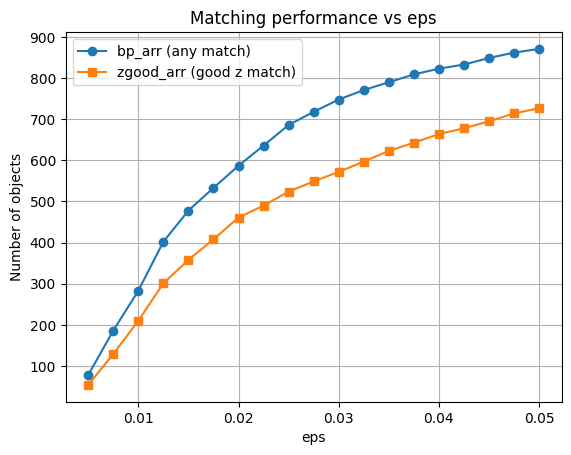

In [12]:
import numpy as np
import matplotlib.pyplot as plt

dz = 0.1
filters = ['g', 'r', 'i', 'z', 'y']

# Create an array of eps values: 0.005, 0.010, ..., 0.050
eps_values = np.arange(0.005, 0.051, 0.0025)
#eps_values = np.array([0.05])
# Arrays to store results
bp_results = []
zgood_results = []

t_hsc = t_hsc_[((t_hsc_['z'] > 0.0) & 
                (t_hsc_['z'] < 1.5) & 
                (t_hsc_['g_kronflux_mag'] > 0) &
                (t_hsc_['r_kronflux_mag'] > 0) &
                (t_hsc_['i_kronflux_mag'] > 0) &
                (t_hsc_['z_kronflux_mag'] > 0) & 
                (t_hsc_['y_kronflux_mag'] > 0))]


# Loop over different eps values
for eps in eps_values:
    zgood_arr = 0  # number of objects with good redshift match
    bp_arr = 0     # number of objects with at least one matched model

    # Loop over the first 1000 objects in the table
    for r in t_hsc[:1000]:
        # Extract magnitudes
        mags = np.array([
            r['g_kronflux_mag'],
            r['r_kronflux_mag'],
            r['i_kronflux_mag'],
            r['z_kronflux_mag'],
            r['y_kronflux_mag']
        ])
        
        # Convert magnitudes to flux
        bandfl = 10 ** (-0.4 * mags)
        bandfl /= np.max(bandfl)  # normalize by max flux

        # Calculate squared distance between model fluxes and observed flux
        rall = np.sum((integrals - bandfl) ** 2, axis=-1)

        # Find indices of models that match the object within tolerance
        idx = np.where(rall < 5 * eps**2)[0]
        #print()
        
        if len(idx) > 0:
            bp_arr += 1  # increment if at least one model matche
        #else:
        #    print(r['ra'], r['dec'], r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag'])
        
        # If there are matches, check if redshift match is within dz
        if len(idx) > 0:
            p_v = params[idx]         # matched model parameters
            z_spec = r['z']           # observed redshift
            z_tmpl = p_v[:, 0]        # model redshift (assumed first column)
            filt_zgood = np.abs(z_tmpl - z_spec) < dz
            n_zgood = np.sum(filt_zgood)
            if n_zgood > 0:
                zgood_arr += 1  # increment if good redshift match found

    # Save results for the current eps
    bp_results.append(bp_arr)
    zgood_results.append(zgood_arr)
    print(f"eps = {eps:.4f}: bp_arr = {bp_arr}, zgood_arr = {zgood_arr}")

# Convert results to numpy arrays
bp_results = np.array(bp_results)
zgood_results = np.array(zgood_results)

# Combine everything into a single results array: [eps, bp, zgood]
results = np.column_stack([eps_values, bp_results, zgood_results])

print("\n✅ Done! Final results:")
print("eps     bp_arr    zgood_arr")
print(results)

# Optional: plot results
plt.plot(eps_values, bp_results, 'o-', label='bp_arr (any match)')
plt.plot(eps_values, zgood_results, 's-', label='zgood_arr (good z match)')
plt.xlabel('eps')
plt.ylabel('Number of objects')
plt.legend()
plt.grid(True)
plt.title('Matching performance vs eps')
plt.show()
